In [1]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# for the persistence diagrams and the betti numbers
import scipy as sp
from matplotlib import cm
import ripser
import persim

# for the persistence landscape
from persim import PersLandscapeApprox, plot_diagrams
from persim.landscapes import plot_landscape_simple

# for running the code faster
import multiprocessing as mp

# to remove the warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Persistent Homology
1. Turn distance matrices into a Rips filtration
2. Look at the Betti numbers for the formations of holes and voids near/during a crash
3. Try characterizing the change in shape with persistence landscapes.

This code is for accessing the data.

This code is for getting the matrices and the betti numbers.

In [2]:
# directory = r"matrices"
# betti_df = pd.DataFrame(columns=["file name", "\u03B20", "\u03B21", "\u03B22"])
# plot_directory = r"trial_pers_hom"

# for name in sorted(os.listdir(directory)):
#     file_path = os.path.join(directory, name)
    
#     if os.path.isfile(file_path) and name.endswith('.pickl'):
#         try:
#             with open(file_path, 'rb') as f:
#                 print(f"Distance matrix of {name}")
#                 data = pickle.load(f)
#                 dist_matrix = data.get('distance matrix')
#                 if dist_matrix is None:
#                     print(f"Distance matrix not found in {name}")
#         except (pickle.UnpicklingError, EOFError, KeyError) as e:
#             print(f"Error loading {name}: {e}")
#             continue
    
#     # this is for making a persistence diagram from a rips filtration 
#     pers_diag = ripser.ripser(dist_matrix, distance_matrix=True, maxdim=2)
#     diagrams = pers_diag['dgms']
    
#     fig, ax = plt.subplots()
#     persim.plot_diagrams(diagrams, ax=ax)
#     plt.title(f'Persistence Diagram for {name}')
#     plt.show()
    
#     # # This is to save the persistence diagram
#     # diagram_path = os.path.join(plot_directory, f"{name}_persistence_diagram.png")
#     # plt.savefig(diagram_path, dpi=300, bbox_inches='tight')
#     # plt.close(fig) 
    
#     # this is to get the betti numbers
#     # Note: will edit this to have more betti numbers later
#     betti_0 = sum(d[1] == np.inf for d in diagrams[0]) if len(diagrams) > 0 else 0
#     betti_1 = len(diagrams[1]) if len(diagrams) > 1 else 0 
#     betti_2 = len(diagrams[2]) if len(diagrams) > 2 else 0 
    
#     new_row = pd.DataFrame({"file name": [name], 
#                             "\u03B20": [betti_0], 
#                             "\u03B21": [betti_1], 
#                             "\u03B22": [betti_2]
#                            }, index=[name])
    
#     betti_df = pd.concat([betti_df, new_row], ignore_index=True)
    
#     # this is to get the persistence landscape
#     for dim in range(2):
#         filtered_diagrams = [d for d in diagrams if len(d) > 0]

#         min_birth, max_death = (
#             min((p[0] for d in diagrams if len(d) > 0 for p in d), default=float("inf")),
#             max((p[1] for d in diagrams if len(d) > 0 for p in d if p[1] != np.inf), default=float("-inf"))
#         )

#         if dim >= len(diagrams) or len(diagrams[dim]) == 0:
#             print(f"Skipping persistence landscape for H{dim} (empty diagram)")
#             continue 
        
#         pla = PersLandscapeApprox(dgms=diagrams, hom_deg=dim, start=min_birth, stop=max_death)
        
#         fig, ax = plt.subplots()
#         ax = plot_landscape_simple(pla, depth_range=range(10))
#         plt.xlabel('time')
#         plt.ylabel('feature prominence')
#         plt.title(f'Persistence Landscape for H{dim}')
#         plt.legend().set_visible(False)
#         plt.show()

#         # # This is to save the persistence landscape
#         # landscape_path = os.path.join(plot_directory, f"{name}_H{dim}_landscape.png")
#         # plt.savefig(landscape_path, dpi=300, bbox_inches='tight')
#         # plt.close(fig)

# betti_df.to_pickle("betti_df.pkl") 

# Betti numbers
Here, I tried to look at the H0 Betti numbers. 

This code is for comparing the number of H0 components to the max filtration.

In [3]:
directory = r"matrices"
plot_directory = r"connected_components"

for name in sorted(os.listdir(directory)):
    file_path = os.path.join(directory, name)
    
    if os.path.isfile(file_path) and name.endswith('.pickl'):
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                dist_matrix = data.get('distance matrix')
                if dist_matrix is None:
                    print(f"Distance matrix not found in {name}")
        except (pickle.UnpicklingError, EOFError, KeyError) as e:
            print(f"Error loading {name}: {e}")
            continue

    # making a persistence diagram from a rips filtration 
    pers_diag = ripser.ripser(dist_matrix, distance_matrix=True, maxdim=2)
    diagrams = pers_diag['dgms']
    thresh_list = np.linspace(0, 1, 50)
    b0_data = []

    for t in thresh_list:
        pers_diag2 = ripser.ripser(dist_matrix, distance_matrix=True, thresh=t, maxdim=2)
        diagrams2 = pers_diag2['dgms']
        b0 = sum(d[1] == np.inf for d in diagrams2[0]) if len(diagrams2) > 0 else 0
        b0_data.append((t, b0))
        
    b0_df = pd.DataFrame(b0_data, columns=['threshold', 'b0'])

    # # trying to normalize the values via percent
    # b0_df['percent'] = b0_df['b0'] / max(b0_data)[1]
    
    # trying to normalize the values via min max
    b0_df['min max'] = (b0_df['b0'] - min(b0_data)[1])/(max(b0_data)[1] - min(b0_data)[1])
    
    # plotting diagrams
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    persim.plot_diagrams(diagrams, plot_only=[0], ax=ax1)
    ax1.set_title('Persistence Diagram')
    
    ax2.plot(b0_df['threshold'], b0_df['min max'])
    ax2.set_xlabel('Death Threshold')
    ax2.set_ylabel('B0 (in percent)')
    ax2.set_title("B0 at Different Thresholds")
    ax2.grid()
    fig.suptitle(f'Connected Components for {name}')
    plt.tight_layout()
    
    # saving the diagram
    diagram_path = os.path.join(plot_directory, f"{name} H0 Connected Components.png")
    # plt.savefig(diagram_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)

KeyboardInterrupt: 

This code is for identifying max threshold and comparing the max threshold across all.

In [ ]:
# directory = r"matrices"
# plot_directory = r"connected_components"
# max_thresh_df = pd.DataFrame(columns=['file name', 'max threshold'])

# for name in sorted(os.listdir(directory)):
#     file_path = os.path.join(directory, name)
    
#     if os.path.isfile(file_path) and name.endswith('.pickl'):
#         try:
#             with open(file_path, 'rb') as f:
#                 data = pickle.load(f)
#                 dist_matrix = data.get('distance matrix')
#                 if dist_matrix is None:
#                     print(f"Distance matrix not found in {name}")
#         except (pickle.UnpicklingError, EOFError, KeyError) as e:
#             print(f"Error loading {name}: {e}")
#             continue

#     t = 0
#     step = 0.005
    
#     while True:
#         pers_diag2 = ripser.ripser(dist_matrix, distance_matrix=True, thresh=t, maxdim=2)
#         diagrams2 = pers_diag2['dgms']
#         b0 = sum(d[1] == np.inf for d in diagrams2[0]) if len(diagrams2) > 0 else 0
        
#         if b0 == 1:
#             new_row = pd.DataFrame([{
#                 "file name": name,
#                 'max threshold': t
#             }])
#             print(new_row)
#             max_thresh_df = pd.concat([max_thresh_df, new_row], ignore_index=True)
#             break
#         else:
#             t += step

This code is for identifying the number of connected components across all.

In [11]:
directory = r"matrices"
max_cc = []

for name in sorted(os.listdir(directory)):
    file_path = os.path.join(directory, name)
    
    if os.path.isfile(file_path) and name.endswith('.pickl'):
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                dist_matrix = data.get('distance matrix')
                if dist_matrix is None:
                    print(f"Distance matrix not found in {name}")
        except (pickle.UnpicklingError, EOFError, KeyError) as e:
            print(f"Error loading {name}: {e}")
            continue

    # making a persistence diagram from a rips filtration 
    pers_diag = ripser.ripser(dist_matrix, distance_matrix=True, maxdim=2)
    diagrams = pers_diag['dgms']
    thresh_list = np.linspace(1e-10, 1e-20, 2)
    b0_data = []

    for t in thresh_list:
        pers_diag2 = ripser.ripser(dist_matrix, distance_matrix=True, thresh=t, maxdim=2)
        diagrams2 = pers_diag2['dgms']
        b0 = sum(d[1] == np.inf for d in diagrams2[0]) if len(diagrams2) > 0 else 0
        b0_data.append((t, b0))
        
    # getting the max number of connected components
    max_cc.append((name, max(b0_data[1])))
    print(name, max(b0_data[1]))

num_cc_df = pd.DataFrame(max_cc, columns=['file name', 'max connected components'])

110 2013-09-26 00:00:00.pickl 193
110 2013-09-27 00:00:00.pickl 193
110 2013-09-30 00:00:00.pickl 193
110 2013-10-01 00:00:00.pickl 193
110 2013-10-02 00:00:00.pickl 193
110 2013-10-03 00:00:00.pickl 193
110 2013-10-04 00:00:00.pickl 193
110 2013-10-07 00:00:00.pickl 193
110 2013-10-08 00:00:00.pickl 193
110 2013-10-09 00:00:00.pickl 193
110 2013-10-10 00:00:00.pickl 193
110 2013-10-11 00:00:00.pickl 193
110 2013-10-14 00:00:00.pickl 193
110 2013-10-15 00:00:00.pickl 193
110 2013-10-16 00:00:00.pickl 193
110 2013-10-17 00:00:00.pickl 193
110 2013-10-18 00:00:00.pickl 193
110 2013-10-21 00:00:00.pickl 193
110 2013-10-22 00:00:00.pickl 193
110 2013-10-23 00:00:00.pickl 193
110 2013-10-24 00:00:00.pickl 193
110 2013-10-25 00:00:00.pickl 193
110 2013-10-28 00:00:00.pickl 193
110 2013-10-29 00:00:00.pickl 193
110 2013-10-30 00:00:00.pickl 193
110 2013-10-31 00:00:00.pickl 193
110 2013-11-01 00:00:00.pickl 193
110 2013-11-04 00:00:00.pickl 193
110 2013-11-05 00:00:00.pickl 193
110 2013-11-06

In [13]:
num_cc_df

,file name,max connected components
0,110 2013-09-26 00:00:00.pickl,193
1,110 2013-09-27 00:00:00.pickl,193
2,110 2013-09-30 00:00:00.pickl,193
3,110 2013-10-01 00:00:00.pickl,193
4,110 2013-10-02 00:00:00.pickl,193
...,...,...
2604,110 2023-09-20 00:00:00.pickl,50
2605,110 2023-09-21 00:00:00.pickl,47
2606,110 2023-09-22 00:00:00.pickl,41
2607,110 2023-09-25 00:00:00.pickl,34


In [14]:
num_cc_df.to_pickle("max connected components.pkl")

In [15]:
filepath = r'fin_files/max connected components.pkl'
with open(filepath, 'rb') as f:
    h0_data = pickle.load(f)
h0_data

,file name,max connected components
0,110 2013-09-26 00:00:00.pickl,193
1,110 2013-09-27 00:00:00.pickl,193
2,110 2013-09-30 00:00:00.pickl,193
3,110 2013-10-01 00:00:00.pickl,193
4,110 2013-10-02 00:00:00.pickl,193
...,...,...
2604,110 2023-09-20 00:00:00.pickl,50
2605,110 2023-09-21 00:00:00.pickl,47
2606,110 2023-09-22 00:00:00.pickl,41
2607,110 2023-09-25 00:00:00.pickl,34


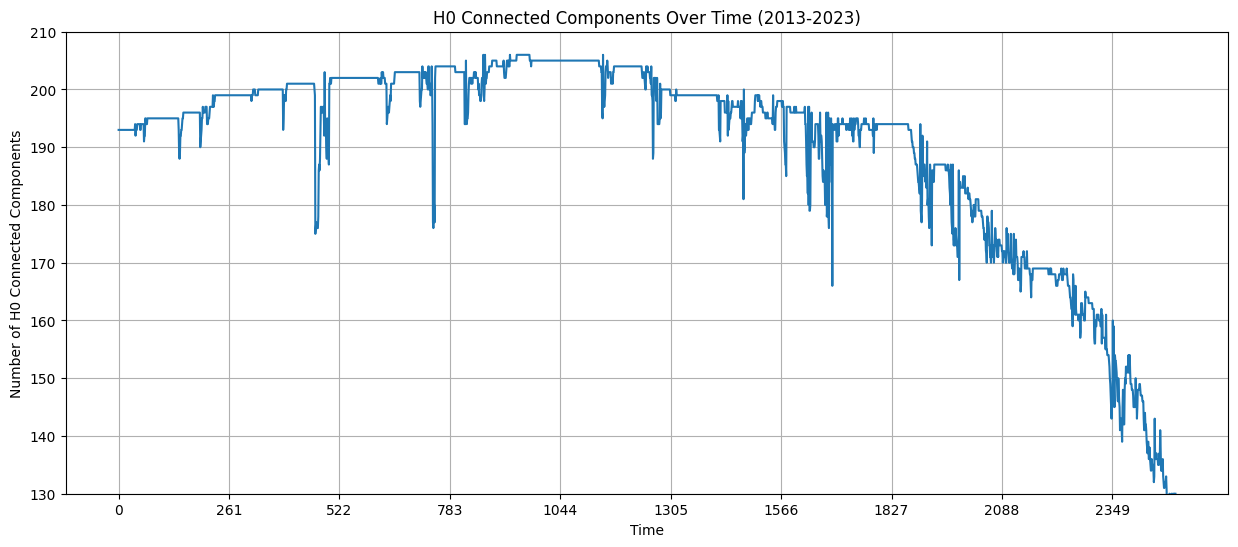

In [42]:
plt.figure(figsize=(15,6))
plt.plot(h0_data.iloc[0:2609-110, 1])
plt.ylim(130, 210)
plt.xticks(range(0, 2610, 261))
# plt.ylim(0.91, 0.97)
plt.title('H0 Connected Components Over Time (2013-2023)')
plt.ylabel('Number of H0 Connected Components')
plt.xlabel('Time')
plt.grid()
plt.show()

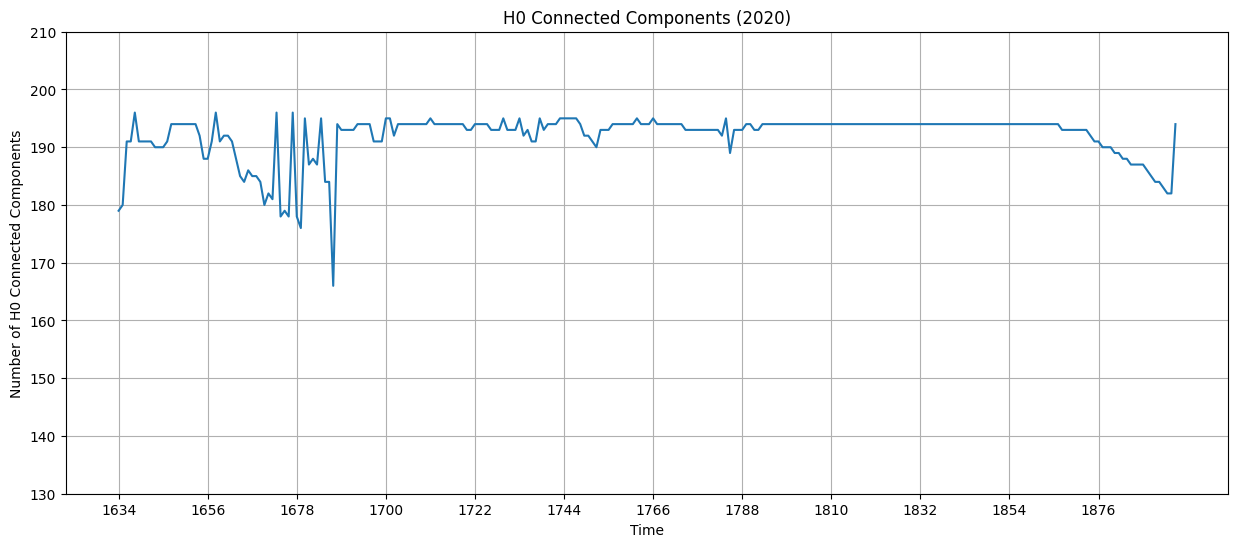

In [47]:
plt.figure(figsize=(15,6))
plt.plot(h0_data.iloc[1634:1896, 1])
#plt.ylim(0.91, 0.97)
plt.ylim(130, 210)
plt.xticks(range(1634, 1897, 22))
plt.title('H0 Connected Components (2020)')
plt.ylabel('Number of H0 Connected Components')
plt.xlabel('Time')
plt.grid()
plt.show()

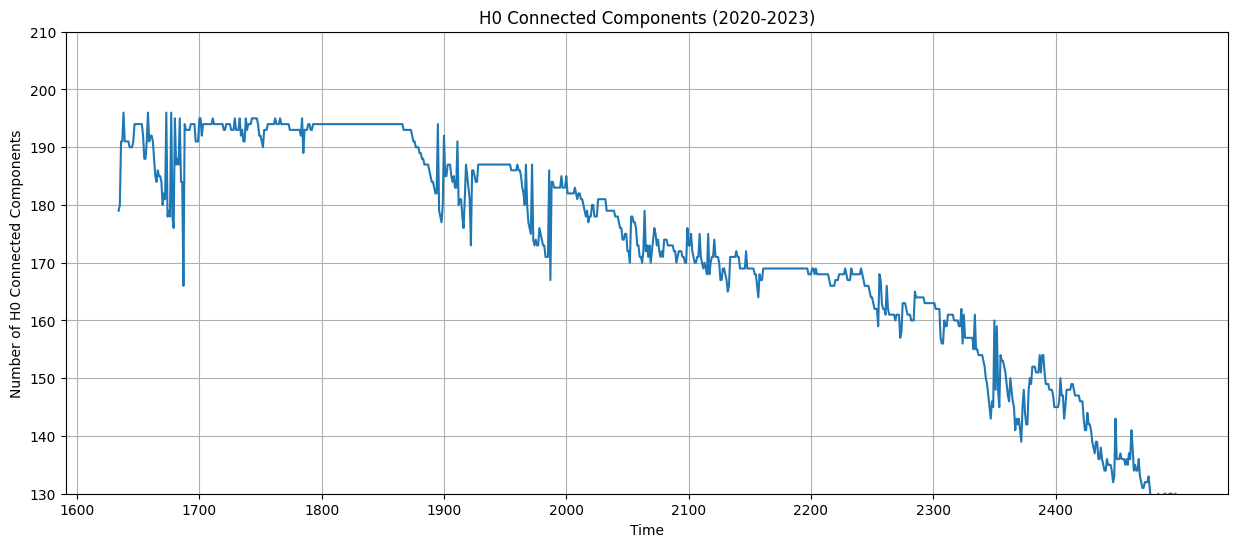

In [45]:
plt.figure(figsize=(15,6))
plt.plot(h0_data.iloc[1634:2609-110, 1])
#plt.ylim(0.91, 0.97)
plt.ylim(130, 210)
plt.xticks(range(1600, 2609-110, 100))
plt.title('H0 Connected Components (2020-2023)')
plt.ylabel('Number of H0 Connected Components')
plt.xlabel('Time')
plt.grid()
plt.show()

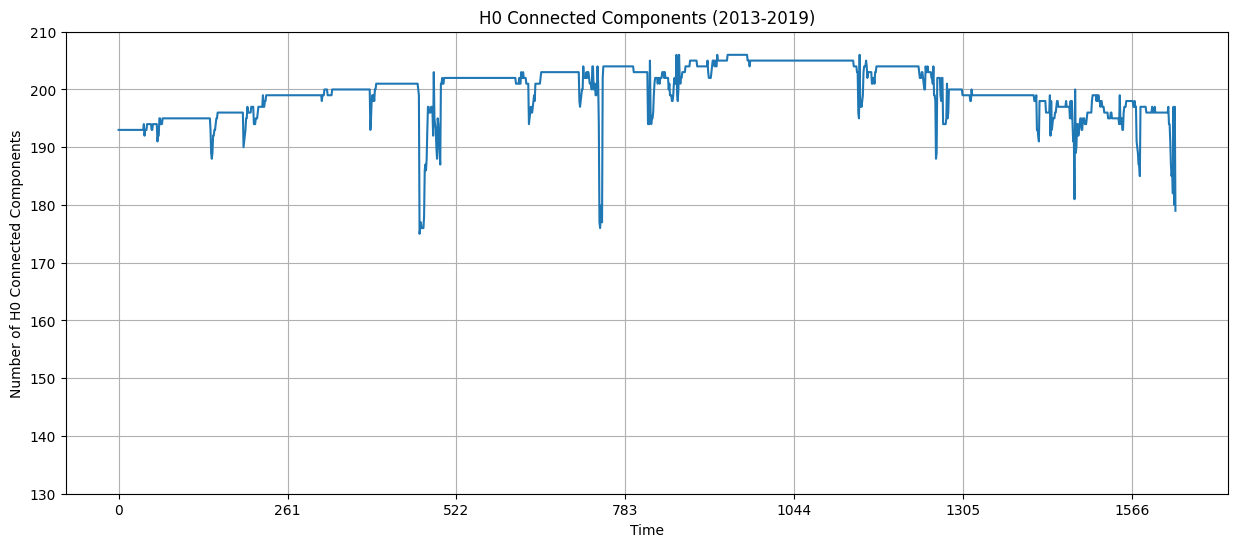

In [44]:
plt.figure(figsize=(15,6))
plt.plot(h0_data.iloc[0:1634, 1])
plt.ylim(130, 210)
plt.xticks(range(0, 1634, 261))
plt.title('H0 Connected Components (2013-2019)')
plt.ylabel('Number of H0 Connected Components')
plt.xlabel('Time')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(h0_data.iloc[0:2609-110, 1])
plt.xticks(range(0, 2610, 261))
plt.ylim(0.91, 0.97)
plt.title('Death of H0 Components Over Time')
plt.ylabel('Max Threshold')
plt.xlabel('Time')
plt.grid()
plt.show()